##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Single Layer Example - Activation Atlas

This notebook uses  [**Lucid**](https://github.com/tensorflow/lucid) to reproduce the results in [Activation Atlas](https://distill.pub/2018/activation-atlas/).

This notebook doesn't introduce the abstractions behind lucid; you may wish to also read the [Lucid tutorial](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb).

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

In [0]:
!pip -q install lucid>=0.3.1
!pip -q install umap-learn>=0.3.5

In [0]:
# General support
import math
import tensorflow as tf
import numpy as np

# For plots
import matplotlib.pyplot as plt

# Dimensionality reduction
import umap
from sklearn.manifold import TSNE

# General lucid code
from lucid.misc.io import save, show, load
import lucid.modelzoo.vision_models as models

# For rendering feature visualizations
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform

In [0]:
 def whiten(full_activations):
  correl = np.matmul(full_activations.T, full_activations) / len(full_activations)
  correl = correl.astype("float32")
  S = np.linalg.inv(correl)
  S = S.astype("float32")
  return S

In [0]:
def umapReduce(d):
  points = umap.UMAP(n_components=2, verbose=True).fit_transform(d)
  points -= points.min(axis=0)
  points /= points.max(axis=0)
  return points

In [0]:
def tsneReduce(d):
  # perplexity between [5, 50]
  # learning_rate usually in the range [10, 1000]
  points = TSNE(n_components=2, verbose=False, metric="cosine", learning_rate=10, perplexity=50).fit_transform(d)
  points -= points.min(axis=0)
  points /= points.max(axis=0)
  return points

In [0]:
def grid(xpts=None, ypts=None, grid_size=8):
  icon_size = 80
  xpx_length = icon_size * grid_size
  ypx_length = xpx_length

  xpt_extent = (xpts.min(), xpts.max())
  ypt_extent = (ypts.min(), ypts.max())
  xpt_length = xpt_extent[1] - xpt_extent[0]
  ypt_length = ypt_extent[1] - ypt_extent[0]

  xpxs = ((xpts - xpt_extent[0]) / xpt_length) * xpx_length
  ypxs = ((ypts - ypt_extent[0]) / ypt_length) * ypx_length


  i_s = range(grid_size)
  xs = []
  for xi in i_s:
    ys = []
    for yi in i_s:
      xpx_extent = (xi * icon_size, (xi + 1) * icon_size)
      ypx_extent = (yi * icon_size, (yi + 1) * icon_size)

      in_bounds_x = np.logical_and(xpx_extent[0] <= xpxs, xpxs <= xpx_extent[1])
      in_bounds_y = np.logical_and(ypx_extent[0] <= ypxs, ypxs <= ypx_extent[1])
      in_bounds = np.logical_and(in_bounds_x, in_bounds_y)

      in_bounds_indices = np.where(in_bounds)[0]
      ys.append(in_bounds_indices)
    xs.append(ys)
  return np.asarray(xs)

In [0]:
@objectives.wrap_objective
def direction_neuron_S(layer_name, vec, batch=None, x=None, y=None, S=None):
  def inner(T):
    layer = T(layer_name)
    shape = tf.shape(layer)
    x_ = shape[1] // 2 if x is None else x
    y_ = shape[2] // 2 if y is None else y
    if batch is None:
      raise RuntimeError("requires batch")

    acts = layer[batch, x_, y_]
    vec_ = vec
    if S is not None: vec_ = tf.matmul(vec_[None], S)[0]
    # mag = tf.sqrt(tf.reduce_sum(acts**2))
    dot = tf.reduce_mean(acts * vec_)
    # cossim = dot/(1e-4 + mag)
    return dot
  return inner


@objectives.wrap_objective
def direction_neuron_cossim_S(layer_name, vec, batch=None, x=None, y=None, cossim_pow=1, S=None):
  def inner(T):
    layer = T(layer_name)
    shape = tf.shape(layer)
    x_ = shape[1] // 2 if x is None else x
    y_ = shape[2] // 2 if y is None else y
    if batch is None:
      raise RuntimeError("requires batch")

    acts = layer[batch, x_, y_]
    vec_ = vec
    if S is not None: vec_ = tf.matmul(vec_[None], S)[0]
    mag = tf.sqrt(tf.reduce_sum(acts**2))
    dot = tf.reduce_mean(acts * vec_)
    cossim = dot/(1e-4 + mag)
    cossim = tf.maximum(0.1, cossim)
    return dot * cossim ** cossim_pow
  return inner


def render_icons(directions, model, layer, size=80, n_steps=128, verbose=False, S=None, num_attempts=2, cossim=True, alpha=True):
  
  image_attempts = []
  loss_attempts = []
  
  # Render two attempts, and pull the one with the lowest loss score.
  for attempt in range(num_attempts):
    
    # Render an image for each activation vector
    param_f = lambda: param.image(size, batch=directions.shape[0], fft=True, decorrelate=True, alpha=alpha)
    if(S is not None):
        if(cossim is True):
            obj_list = ([
              direction_neuron_cossim_S(layer, v, batch=n, S=S, cossim_pow=4) for n,v in enumerate(directions)
            ]) 
        else: 
            obj_list = ([
              direction_neuron_S(layer, v, batch=n, S=S) for n,v in enumerate(directions)
            ])    
    else: 
        obj_list = ([
          objectives.direction_neuron(layer, v, batch=n) for n,v in enumerate(directions)
        ])

    obj = objectives.Objective.sum(obj_list)

    transforms = []
    if alpha:
      transforms.append(transform.collapse_alpha_random())
    transforms.append(transform.pad(2, mode='constant', constant_value=1))
    transforms.append(transform.jitter(4))
    transforms.append(transform.jitter(4))
    transforms.append(transform.jitter(8))
    transforms.append(transform.jitter(8))
    transforms.append(transform.jitter(8))
    transforms.append(transform.random_scale([0.995**n for n in range(-5,80)] + [0.998**n for n in 2*list(range(20,40))]))
    transforms.append(transform.random_rotate(list(range(-20,20))+list(range(-10,10))+list(range(-5,5))+5*[0]))
    transforms.append(transform.jitter(2))

    # This is the tensorflow optimization process
  
    print("attempt: ", attempt)
    with tf.Graph().as_default(), tf.Session() as sess:
      learning_rate = 0.05
      losses = []
      trainer = tf.train.AdamOptimizer(learning_rate)
      T = render.make_vis_T(model, obj, param_f, trainer, transforms)
      loss_t, vis_op, t_image = T("loss"), T("vis_op"), T("input")
      losses_ = [obj_part(T) for obj_part in obj_list]
      tf.global_variables_initializer().run()
      for i in range(n_steps):
        loss, _ = sess.run([losses_, vis_op])
        losses.append(loss)
        if (i % 10 == 0):
            print(i)

      img = t_image.eval()
      img_rgb = img[:,:,:,:3]
      if alpha:
        print("alpha true")
        k = 0.8
        bg_color = 0.0
        img_a = img[:,:,:,3:]
        img_merged = img_rgb*((1-k)+k*img_a) + bg_color * k*(1-img_a)
        image_attempts.append(img_merged)
      else:
        print("alpha false")
        image_attempts.append(img_rgb)

      loss_attempts.append(losses[-1])

  # Use only the icons with the lowest loss
  loss_attempts = np.asarray(loss_attempts)   
  loss_final = []
  image_final = []
  print("merging best scores from attempts...")
  for i, d in enumerate(directions):
    # note, this should be max, it is not a traditional loss
    mi = np.argmax(loss_attempts[:,i])
    image_final.append(image_attempts[mi][i])
    
  return (image_final, loss_final)

In [0]:
model = models.InceptionV1()
model.load_graphdef()

In [63]:
# 7 = mixed4c
layer = "mixed4c"
print(model.layers[7])
raw_activations = model.layers[7].activations
activations = raw_activations[:100000]
print(activations.shape)

Layer (belonging to InceptionV1) <mixed4c: 512> ([{'conv'}])
(100000, 512)


In [0]:
S = whiten(raw_activations)

In [52]:
layout = umapReduce(activations)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  17
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	 7  /  17
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


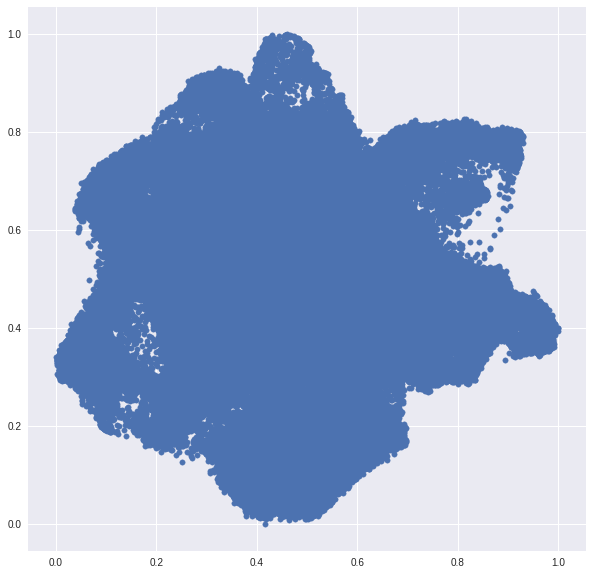

In [53]:
plt.figure(figsize=(10, 10))
plt.scatter(x=layout[:,0],y=layout[:,1], s=10)
plt.show()

In [0]:
size = 16
grid_layout = grid(xpts=layout[:,0], ypts=layout[:,1], grid_size=size)

In [0]:
number_of_activations_threshold = 10
icons = []
for x in range(size):
    for y in range(size):
        indices = grid_layout[x, y]
        if len(indices) > number_of_activations_threshold:
            average_activation = np.average(activations[indices], axis=0)
            icons.append((average_activation, x, y))

icons = np.asarray(icons)

In [60]:
icon_size = 80
num_attempts = 1
icon_batch, losses = render_icons(icons[:,0], model, alpha=False, layer=layer, S=S, n_steps=1024, size=icon_size, num_attempts=num_attempts)

attempt:  0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
alpha false
merging best scores from attempts...


In [62]:
scale_factor = 1.0
xi = int(size * scale_factor)
canvas = np.ones((icon_size * xi, icon_size * xi, 3))
for i, icon in enumerate(icon_batch):
    x = int(icons[i, 1])
    y = int(icons[i, 2])
    canvas[x * icon_size:(x + 1) * icon_size, y * icon_size:(y + 1) * icon_size] = icon

save(canvas, "activ.jpg")
show(canvas)